[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python

## Setup

In [2]:
import operator
import os, getpass
from typing import List, Annotated, TypedDict
from IPython.display import Markdown
from langgraph.constants import Send
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import get_buffer_string
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "PI"

llm = ChatOpenAI(model="gpt-4o",temperature=0)
tavily_search = TavilySearchResults(max_results=3)

/Users/tomer/projects/RorschachTestChatBot/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


OPENAI_API_KEY:  ········
TAVILY_API_KEY:  ········
LANGCHAIN_API_KEY:  ········


# PI - Main Idea

Investigating Paper Originality with LangChain
Conducting a comprehensive literature review is often a time-intensive and challenging task, particularly when faced with evaluating the originality of multiple papers. Manually assessing the novelty of each paper is impractical, leading us to seek an automated and scalable solution.

To address this challenge, we propose building a LangGraph—a system designed to automate the originality assessment process. The LangGraph operates as follows:

Input: A text document (e.g., a three-page research paper).
Output: A concise, detailed report evaluating the originality of the paper.

The system relies on two key components:

### Web Search Agent:
This agent is designed to search the web for specific sentences extracted from the input text. For each sentence, it identifies whether the same or similar content exists online. If matches are found, the agent compiles relevant information, including the source, and adds it to the findings.

### PI Team Leader Agent:
Acting as the orchestrator, this agent breaks the input text into individual sentences and delegates them to multiple web search agents. Once the findings are collected, the team leader agent synthesizes the results into a structured and insightful report that highlights the originality (or lack thereof) of the paper.

By automating these tasks, LangGraph provides a scalable and efficient alternative to manual literature reviews.

![alt text](https://www.onlinespyshop.co.uk/media/magefan_blog/top_methods_employed_by_private_detectives.jpg)

# Find Cheater

## The Problem of A single sentence

### Look for sources online

The PI(private investigator) will gather information from a web search sources (using Tavily) to look for its given sentence seperatly.

Tavily is a great choice for this kind of task because it is not limited to one specific source.

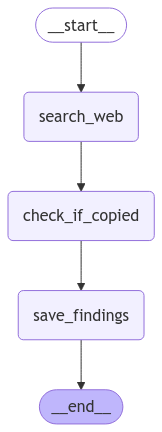

In [33]:
class PrivateInvestigatorState(MessagesState):
    context: Annotated[list, operator.add] # Source docs
    findings: Annotated[list, operator.add] # Final key we duplicate in outer state for Send() API
    search_query: str 

def search_web(state: PrivateInvestigatorState):
    
    """ Retrieve docs from web search """
    
    # Search
    query= state['search_query']
    search_docs = tavily_search.invoke(query)
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 


pi_instructions = """can you find '{query}' in the following context:
{context}
I am trying to see if someone cheated the test or not
I am just interested to know if this sentence was copied, so if you find the exact sentence in the context please let me know.
for your task:
1. use only the information provided in the context. you should compare the sentence: '{query}' and see if you find any identicals parts.
2. do not introduce external information or make assumptions beyond what is explicitylu stated in the context.
3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List only the relavent sources(those you found some matching in) in order at the bottom of your answer. [1] Source 1, [2] Source 2,
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_finding(state: PrivateInvestigatorState):
    
    """ Node to see if the sentence is in any of Tavily search results """

    # Get state
    messages = state["messages"]
    context = state["context"]
    query = state["search_query"]
    # Answer question
    system_message = pi_instructions.format(context=context, query = query)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "PI"
    
    # Append it to state
    return {"messages": [answer]}

def save_findings(state: PrivateInvestigatorState):
    
    """ Save Findings """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    findings = get_buffer_string(messages)
    
    # Save to interviews key
    return {"findings": [findings]}



# Add nodes and edges 
pi_builder = StateGraph(PrivateInvestigatorState)
pi_builder.add_node("search_web", search_web)
pi_builder.add_node("check_if_copied", generate_finding)
pi_builder.add_node("save_findings", save_findings)

# Flow
pi_builder.add_edge(START, "search_web")
pi_builder.add_edge("search_web", "check_if_copied")
pi_builder.add_edge("check_if_copied", "save_findings")
pi_builder.add_edge("save_findings", END)

# Interview 
memory = MemorySaver()
pi_graph = pi_builder.compile(checkpointer=memory).with_config(run_name="PI run")

# View
display(Image(pi_graph.get_graph().draw_mermaid_png()))

In [34]:
thread = {"configurable": {"thread_id": "1"}}
output = pi_graph.invoke({"messages": [HumanMessage(f"")], 'search_query':'article on clounds'}, thread)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================
Name: PI

The sentence 'article on clounds' does not appear in any of the provided documents. There are no identical parts found in the context. Therefore, no sources are relevant for this sentence.


In [35]:
messages = [HumanMessage(f"")]
thread = {"configurable": {"thread_id": "2"}}
output = pi_graph.invoke({"messages": messages, 'search_query':'The higher the base of a cloud is, the drier the atmosphere and the fairer the weather will be'}, thread)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================
Name: PI

The sentence "The higher the base of a cloud is, the drier the atmosphere and the fairer the weather will be" is found in the context provided. It appears in the document sourced from "https://education.nationalgeographic.org/resource/cloud/".

Relevant source:
[2] https://education.nationalgeographic.org/resource/cloud/


### Parallelze PI search: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write a conclusion to the final report.

In [36]:
class ResearchGraphState(TypedDict):
    source_text: str # original text to look for cheaters from.
    queries: List[str] # queries to search for
    findings: Annotated[list, operator.add] # Send() API key
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

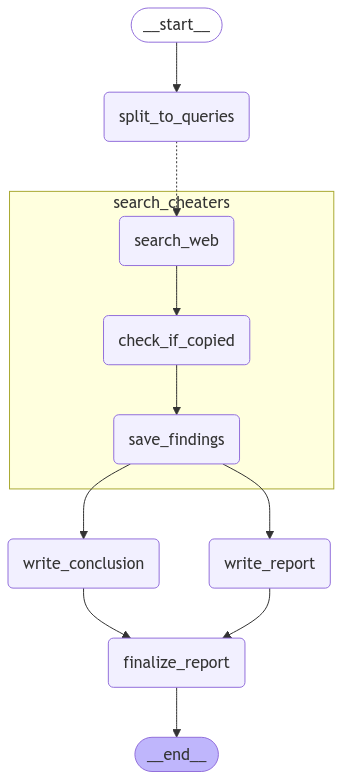

In [48]:
text_splitter_instructions = """split the following text into sentences with the word "split_here" in between:
{text} """
def split_to_queries(state: ResearchGraphState):
    text = state['source_text']
    system_message = text_splitter_instructions.format(text=text)    
    splitted_sentences = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"split me the sentences based on the provided text")]) 
    return {'queries': splitted_sentences.content.split('split_here')}
    
def map_search(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    
 
    return [Send("search_cheaters", {"search_query": query, "messages": [HumanMessage(content=f"")]}) for query in state["queries"]]

report_writer_instructions = """You are a technical writer creating a report 
    
You have a team of PI(private investigators). Each PI has done two things: 

1. They have searched the web for copied parts in a paper.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your PI.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that conclude the findings, whether the paper was copied and if so how much of it was copied. 
4. Summarize the central points in each memo into a cohesive single narrative.
5. ignore anything related to the text:'You are trained on data up to October 2023'
To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any PI names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your PIs to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of findings
    findings = state["findings"]

    # Concat all findings together
    formatted_str_findings = "\n\n".join([f"{finding}" for finding in findings])
    
    # Summarize the findings into a final report
    system_message = report_writer_instructions.format(context=formatted_str_findings)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a the PI(private investigators) team leader.

You will be given all of the findings of the investigators.

You job is to write a crisp conclusion section.

Include no pre-amble for either section.

Target around 100 words, crisply recapping (for conclusion) all of the findings of the report.

Note, that you are mainly interested in the verdict, meaning, was there any copying or not.

Use markdown formatting. 

For your conclusion, use ## Conclusion as the section header.
Ignore anything related to the text:'You are trained on data up to October 2023'

Here are the findings to reflect on for writing: {formatted_str_findings}"""


def write_conclusion(state: ResearchGraphState):
    # Full set of findings
    findings = state["findings"]

    # Concat all findings together
    formatted_str_findings = "\n\n".join([f"{finding}" for finding in findings])
    
    # Summarize the findings into a final report
    
    instructions = intro_conclusion_instructions.format(formatted_str_findings=formatted_str_findings)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the findings, combine them, and reflect on them to write the conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("split_to_queries", split_to_queries)
builder.add_node("search_cheaters", pi_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "split_to_queries")
builder.add_conditional_edges("split_to_queries", map_search,['search_cheaters'])
builder.add_edge("search_cheaters", "write_report")
builder.add_edge("search_cheaters", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [49]:
# Inputs
source_text = """to PLMs, LLMs are not only much larger in model size, but
also exhibit stronger language understanding and generation
abilities, and more importantly, emergent abilities that are
not present in smaller-scale language models. As illustrated
in Fig. 1, these emergent abilities include (1) in-context
learning, where LLMs learn a new task from a small set
of examples presented in the prompt at inference time, (2)
instruction following, where LLMs, after instruction tuning."""
thread = {"configurable": {"thread_id": "1"}}

# Run the graph with the example text
for event in graph.stream({"source_text":source_text}, 
                          thread, 
                          stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
split_to_queries
--Node--
search_cheaters
--Node--
search_cheaters
--Node--
search_cheaters
--Node--
search_cheaters
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [50]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)



---



The investigation into the paper reveals several instances of potential copying from existing sources. A specific sentence, "to PLMs, LLMs are not only much larger in model size, but," was found verbatim in a document available on arxiv.org [1]. This indicates a direct match with the source material.

Another sentence, "also exhibit stronger language understanding and generation abilities, and more importantly, emergent abilities that are not present in smaller-scale language models," was not found verbatim but shares thematic similarities with discussions in documents from dl.acm.org and arxiv.org [1][2]. This suggests that while the exact wording was not copied, the ideas may have been heavily influenced by these sources.

A third sentence, "As illustrated in Fig. 1, these emergent abilities include (1) in-context learning, where LLMs learn a new task from a small set of examples presented in the prompt at inference time, (2) instruction following, where LLMs, after instruction tuning," was not found verbatim in any of the reviewed documents, indicating no direct copying for this part.

Overall, the findings suggest that while there is a clear instance of verbatim copying, other parts of the paper may have been influenced by existing literature without direct copying. The extent of copying is limited to specific sentences, with thematic similarities noted in other sections.


---

## Conclusion

The investigation into potential copying has revealed mixed findings. The sentence "to PLMs, LLMs are not only much larger in model size, but" was found verbatim in the document from arxiv.org, indicating a direct match. However, the sentence "also exhibit stronger language understanding and generation abilities, and more importantly, emergent abilities that are not present in smaller-scale language models" was not found verbatim, though similar themes were noted in related documents. Additionally, the sentence regarding emergent abilities and instruction following was not found verbatim in any context. Overall, there is partial evidence of copying, but not conclusively across all examined sentences.

## Sources

[1] arxiv.org/pdf/2402.06196
[2] https://dl.acm.org/doi/10.5555/3666122.3668547
[3] https://arxiv.org/abs/2304.15004

In [51]:
# Inputs
source_text = """My name is Tomer Weiss, I am a Data Scientist trying to pass a home exam for Tavily.
I hope my work is good enough, it is my first langChain project and I have learned a lot from it.
Please Hire me, I am a good hard worker :)"""
thread = {"configurable": {"thread_id": "2"}}

# Run the graph with the example text
for event in graph.stream({"source_text":source_text}, 
                          thread, 
                          stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
split_to_queries
--Node--
search_cheaters
--Node--
search_cheaters
--Node--
search_cheaters
--Node--
search_cheaters
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [52]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)



---



The investigation into the paper reveals that there are no instances of verbatim copying from the provided context. Each sentence examined by the investigators was found to be original, with no identical parts detected in the context or documents reviewed. The sentences analyzed include personal statements and expressions of intent, which do not appear in any external sources. Therefore, the paper in question does not contain copied content.


---

## Conclusion

Based on the investigation, there is no evidence of verbatim copying in the provided context. The sentences "My name is Tomer Weiss, I am a Data Scientist trying to pass a home exam for Tavily," "I hope my work is good enough, it is my first langChain project and I have learned a lot from it," and "Please Hire me, I am a good hard worker :)" do not appear in the context or any listed documents. The phrase "You are trained on data up to October 2023" is not found verbatim but appears in similar forms across multiple sources. Overall, no direct copying was identified.

## Sources

[1] marshables.com/you-are-trained-on-data-up-to-october-2023/  
[2] runpost.net/you-are-trained-on-data-up-to-october-2023/  
[3] ivanaturfturf.com/you-are-trained-on-data-up-to-october-2023/